# Latent Dirichlet Allocation for Topic Analysis

Performs LDA on lit review abstracts for SGSMA.  Both term frequency and term frequency/inverse document frequency (TFIDF) are explored.

# Imports

In [58]:
%matplotlib notebook
import csv
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.externals import joblib
from nltk.probability import FreqDist

import warnings
warnings.filterwarnings('ignore')


sns.set_style('whitegrid')
sns.set_context('notebook')

# Read in doc metadata

In [4]:
doc_lookup = {}
with open("data/lit-review-doc-metadata.csv", "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        doc_lookup[row["Document Title"]] = row

print(len(doc_lookup.keys()))

9734


# Filter docs

In [6]:
not_found = 0
with open("data/lit-review-categories.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row["Document Title"] in doc_lookup:
            doc_lookup[row["Document Title"]]["Label"] = row["Domain"]
        else:
            not_found += 1

print("Missing docs: {}".format(not_found))

ignore = [
    "Exclude",
    "Overview",
    "PMU Placement",
    "PMU",
    "PDC",
    "Unknown",
    "Undefined",
    "Control",
    "Communications",
    "Phasor Estimation",
    "Simulation",
    "Islanding",
    "Time Synchronization"
    "Testing",
    "Real Time Operations",
    "Tools",
    "EMS",
    "Standards",
    "",
    "Phasor estimation",
    "Protection Systems"
]

docs = [d for d in doc_lookup.values() if "Label" in d and d["Label"] not in ignore] 
print("Filtered docs: {}".format(len(docs)))

corpus = [d["Abstract"] for d in docs]

Missing docs: 296
Filtered docs: 3872


# Create and Fit LDA model

In [46]:
# params
no_topics = 40
no_features = 750

# vectorize words
tf_vectorizer = CountVectorizer(max_df=0.8, min_df=2, max_features=no_features, stop_words='english', ngram_range=(1,3))
tf = tf_vectorizer.fit_transform(corpus)
tf_feature_names = tf_vectorizer.get_feature_names()

# create separate tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


# Create/fit models
lda_tf = LatentDirichletAllocation(
    n_components=no_topics, 
    random_state=0).fit(tf)

lda_tfidf = LatentDirichletAllocation(
    n_components=no_topics, 
    random_state=0).fit(tfidf)

Save model and related data to disk for separate analysis

In [47]:
joblib.dump({"model": lda_tf, "dtm": tf, "vectorizer": tf_vectorizer, "docs": docs}, 'lda_tf_review.joblib') 

['lda_tf_review.joblib']

# Display top words per topic

In [48]:
no_top_words = 10

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}: {}".format(
            topic_idx,
            " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        ))

## Term Frequency

In [49]:
display_topics(lda_tf, tf_feature_names, no_top_words)

Topic 0: sensor sensors propose respect effectiveness proposed best grid devices operators optimal
Topic 1: generator effective source shown method low frequency oscillations matrix frequency forced
Topic 2: bus ieee proposed test using method new 39 power systems
Topic 3: network neural networks power network neural network stage voltages nodes graph algorithm
Topic 4: current voltage method technique based impedance classification proposed learning using
Topic 5: problem algorithm optimization optimal approach proposed solution model set paper
Topic 6: signal signals event events small frequency small signal features processing time
Topic 7: pmu data phasor measurement unit phasor measurement pmu data measurement unit phasor measurement unit unit pmu
Topic 8: equipment technology data substation paper level proposed monitor statistical monitoring
Topic 9: model transmission line line transmission performance measures order network accuracy reliability
Topic 10: topology series time s

## Term Frequency / Inverse Document Frequency

In [50]:
display_topics(lda_tfidf, tfidf_feature_names, no_top_words)

Topic 0: parameters line parameter line parameters estimate considering static estimation state estimation method proposed
Topic 1: modes operators critical order pmu locations bus modal robust introduced
Topic 2: prediction model proposed dynamic risk based power ieee decomposition bus
Topic 3: model estimation network algorithms conditions power attacks evaluation measurements pmu
Topic 4: impedance method feeder power monitoring reactive estimates conditions strategy distribution
Topic 5: se matrix state proposed robust cyber physical pmu states method
Topic 6: bad data events bad signals signal time time synchronization features distance synchronization
Topic 7: state estimation state estimation measurements estimator measurement data method state estimator power
Topic 8: attacks data estimation currents method achieved voltages measurements robustness states
Topic 9: transmission line model transmission line uncertainty line parameters optimization robust models verify
Topic 10: s

# Find predictions for training data

In [51]:
tf_predictions = np.argmax(lda_tf.transform(tf), axis=1)
tfidf_predictions = np.argmax(lda_tfidf.transform(tfidf), axis=1)
(tf_predictions.shape, tfidf_predictions.shape)

((3872,), (3872,))

In [74]:
def plot_topic_distribution(predictions, title):
    fix, ax = plt.subplots()
    g = sns.distplot(predictions, bins=no_topics, norm_hist=False, kde=False, color="", ax=ax)
    ax.set_xlabel("topics")
    ax.set_ylabel("document count")
    ax.set_title(title)

#     series = pd.Series(predictions)
#     _ = series.hist(bins=no_topics, ax=ax)

In [93]:
def plot_topic_distribution(predictions, title, save=None):
    fix, ax = plt.subplots(figsize=(9,6))
    ax.set_xlabel("topics")
    ax.set_ylabel("document count")
    ax.set_title(title)
    ax.grid('false', which='x')
        
    series = pd.Series(predictions)
    _ = series.hist(bins=no_topics, ax=ax)
    
    if save:
        plt.savefig(save)
    

<IPython.core.display.Javascript object>


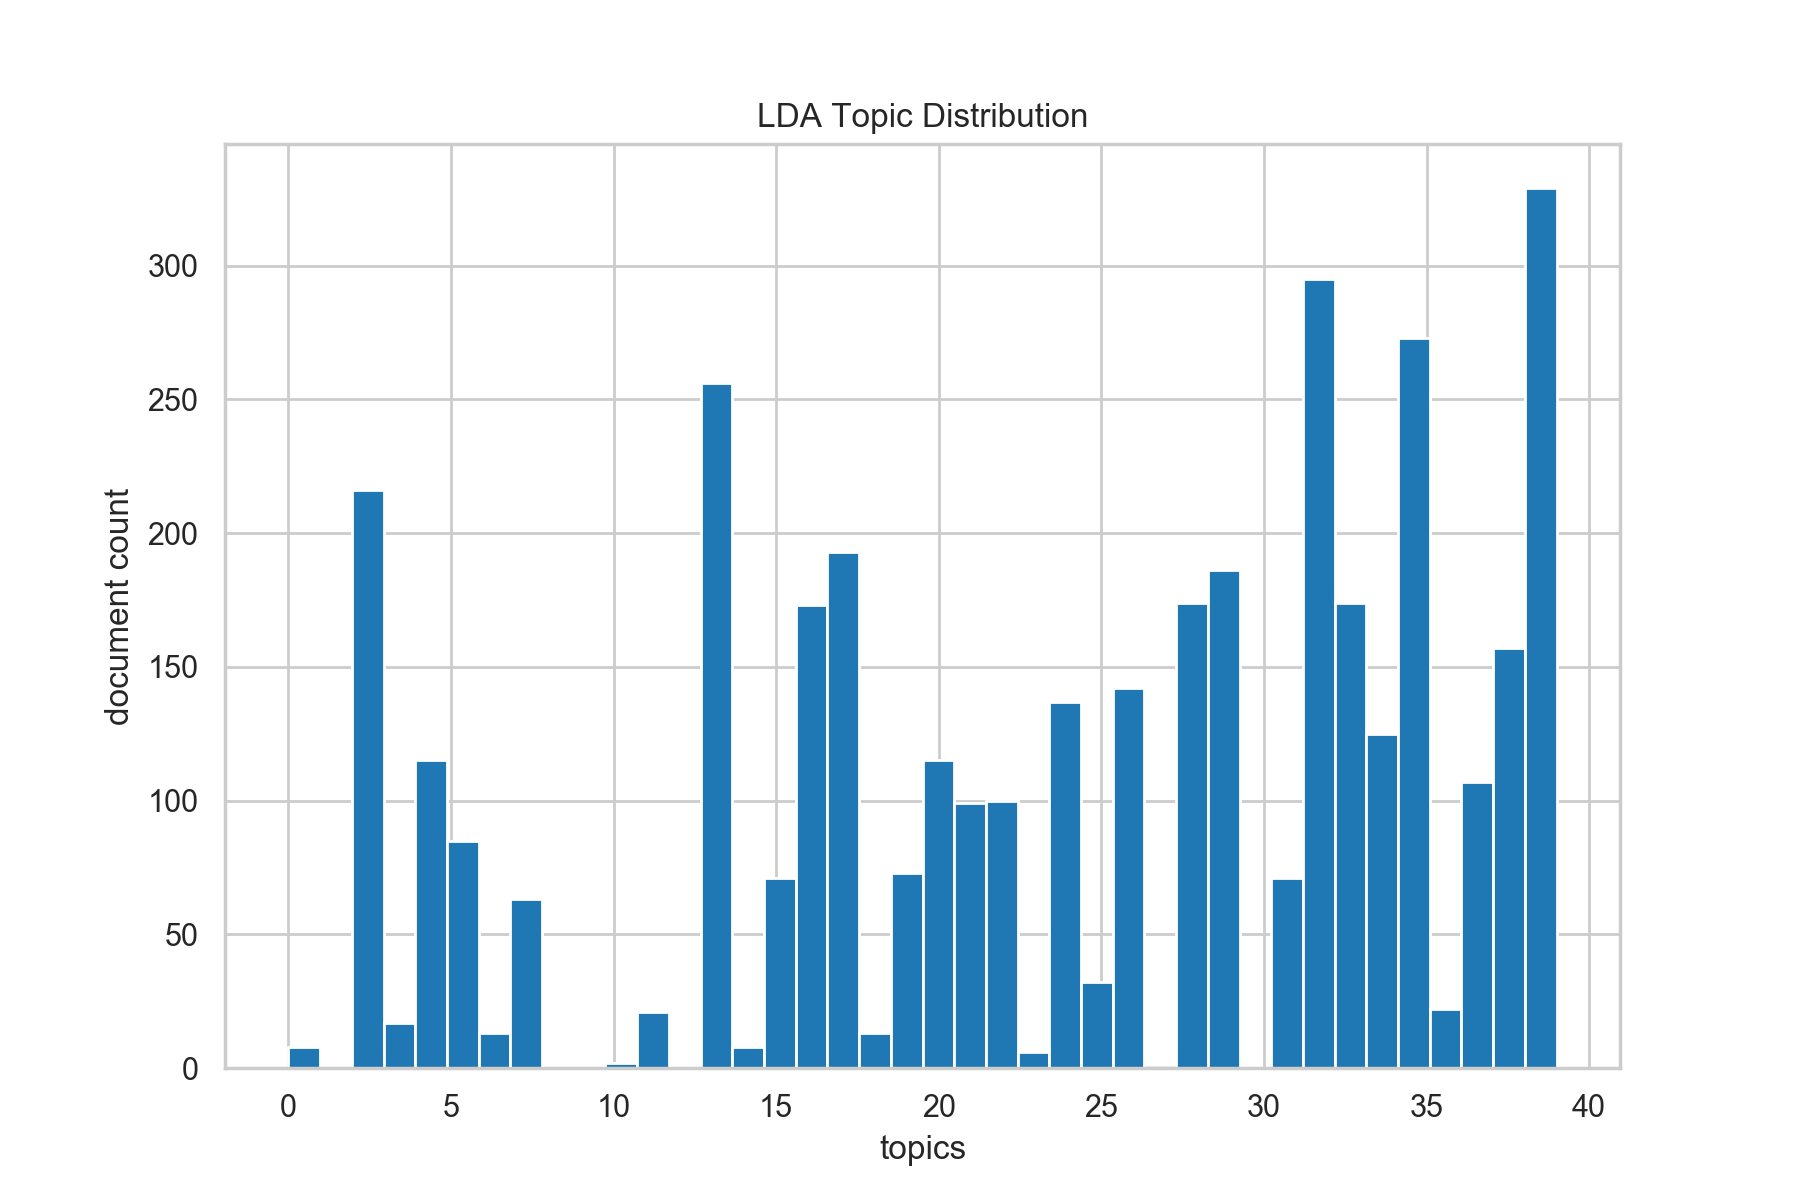

In [94]:
plot_topic_distribution(tf_predictions, "LDA Topic Distribution", save="topic_distribution.png")

<IPython.core.display.Javascript object>


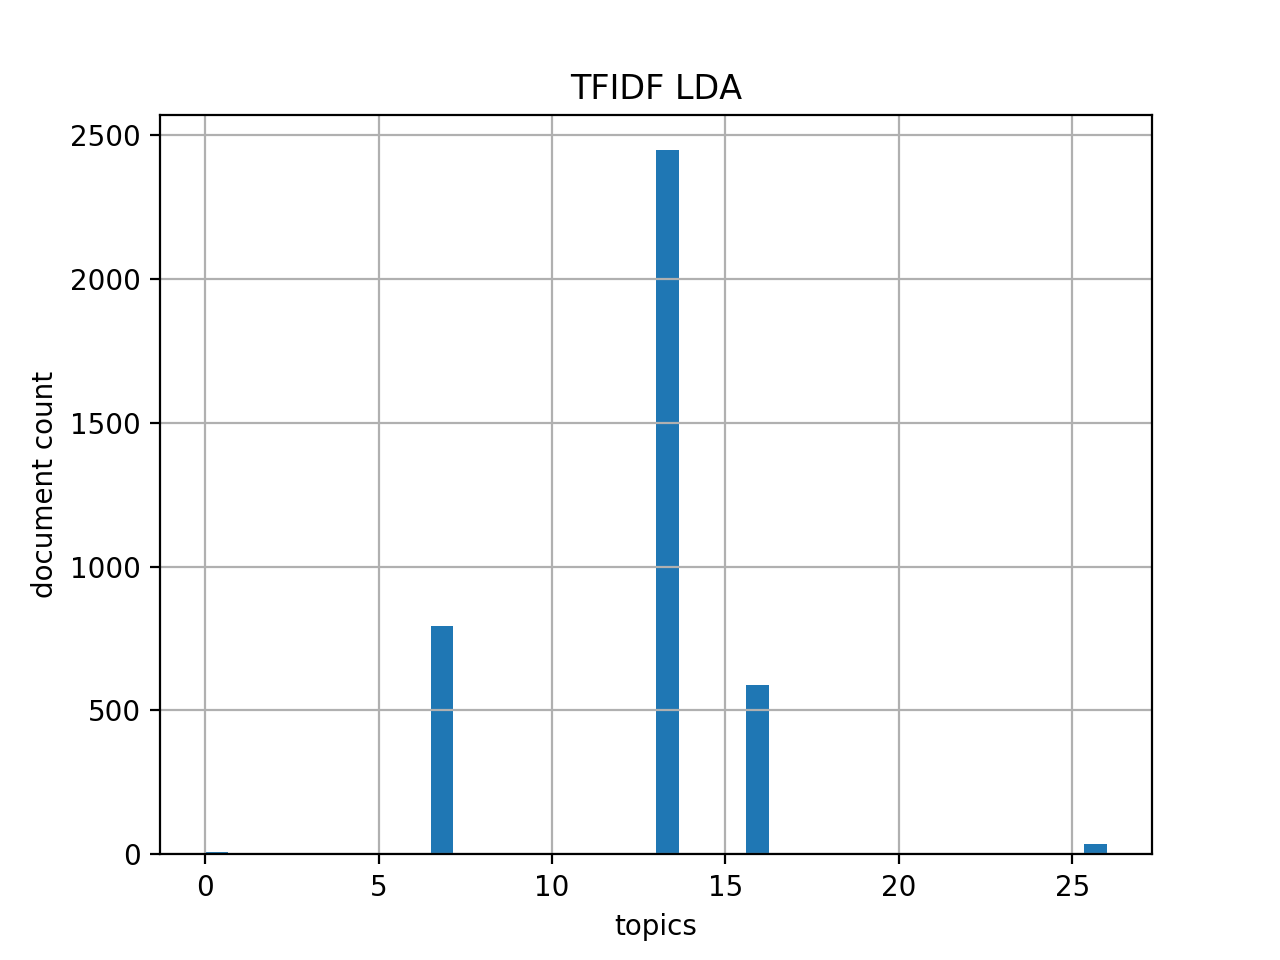

In [54]:
plot_topic_distribution(tfidf_predictions, "TFIDF LDA")

# Interactive Topic Explorer

In [16]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, Output
from IPython.display import display, clear_output

## TF Explorer

In [14]:
tf_freq = FreqDist(tf_predictions)
out1 = Output()

def f_tf(topic):
    indexes = np.where(tf_predictions==topic)[0]
    text = []
    with out1:
        clear_output()
        for idx in indexes:
            print("- {}".format(docs[idx]["Document Title"]))
        

interact(f_tf, topic=sorted([("Topic {}: {} docs".format(k, v), k) for k, v in tf_freq.items()], key=lambda d: d[1]))
display(out1)

interactive(children=(Dropdown(description='topic', options=(('Topic 0: 83 docs', 0), ('Topic 1: 270 docs', 1)…

Output()

## TFIDF Explorer

In [15]:
tfidf_freq = FreqDist(tfidf_predictions)
tfidf_out = Output()

def tfidf_f(topic):
    indexes = np.where(tfidf_predictions==topic)[0]
    with tfidf_out:
        clear_output()
        for idx in indexes:
            print("- {}".format(docs[idx]["Document Title"]))
        

interact(tfidf_f, topic=sorted([("Topic {}: {} docs".format(k, v), k) for k, v in tfidf_freq.items()], key=lambda d: d[1]))
display(tfidf_out)

interactive(children=(Dropdown(description='topic', options=(('Topic 0: 16 docs', 0), ('Topic 15: 12 docs', 15…

Output()

## Topic Word Visual Explorer

In [17]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [76]:
# MMDS and TSNE can be used for plotting rather than the default PCoA
pyLDAvis.sklearn.prepare(lda_tf, tf, tf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=           Freq  cluster  topics          x          y
topic                                                 
32     6.297172        1       1 -39.064602 -43.963276
35     5.783133        1       2  -9.386237  53.416473
39     5.738754        1       3  42.365292  24.237484
2      5.047129        1       4  14.797322  -0.951605
16     4.818657        1       5   3.425964  14.066346
13     4.438809        1       6 -53.847054 -26.553244
26     4.047827        1       7 -31.645298 -25.932360
29     3.821403        1       8 -17.860350 -40.731190
17     3.769506        1       9 -23.125227 -61.743565
33     3.669575        1      10  -8.120272  28.366480
38     3.638685        1      11  -0.181184 -53.124809
20     3.515823        1      12 -28.423878  -5.457940
24     3.457107        1      13  26.646639 -22.872927
28     3.392343        1      14 -47.616486  -7.178589
22     3.301901        1      15  21.990023  17.546419
4      3.300541        1      16 -19.595558  14.590123
5      3.231686        1      17  36.204659  -0.749689
34     2.682933        1      18 -82.769684 -27.371717
7      2.552967        1      19 -18.664085  71.146339
21     2.533549        1      20  17.434782 -42.036674
37     2.493155        1      21 -42.206425  13.359451
31     2.318238        1      22  65.825142   5.781602
19     2.177000        1      23  12.570464  37.033909
15     1.851732        1      24  45.989090  43.676506
25     1.802979        1      25  19.428009  62.056850
3      1.587843        1      26 -31.339703  38.093864
11     1.394150        1      27  21.673473 -67.484810
6      1.348633        1      28 -69.505669   0.008035
14     1.325169        1      29  43.459503 -51.094326
18     1.241155        1      30 -57.987896  32.611595
23     1.193559        1      31  52.844639 -24.813139
36     0.806493        1      32 -64.164742 -58.036228
27     0.597230        1      33 -39.296425 -84.342049
10     0.433118        1      34 -53.379715  61.601444
0      0.122879        1      35  -1.977947 -87.355743
30     0.121480        1      36 -90.404823  20.979187
9      0.036422        1      37   4.967388 -16.044798
12     0.036422        1      38  -0.771798 -30.669718
1      0.036422        1      39  -7.627934  -4.211387
8      0.036422        1      40 -13.235406 -19.562935, topic_info=     Category         Freq                Term        Total  loglift  logprob
term                                                                         
237   Default  1861.000000               fault  1861.000000  30.0000  30.0000
132   Default  4057.000000                data  4057.000000  29.0000  29.0000
625   Default  2685.000000               state  2685.000000  28.0000  28.0000
477   Default  1956.000000                 pmu  1956.000000  27.0000  27.0000
409   Default  1616.000000             network  1616.000000  26.0000  26.0000
351   Default  1275.000000                load  1275.000000  25.0000  25.0000
347   Default  1373.000000                line  1373.000000  24.0000  24.0000
677   Default  2950.000000                time  2950.000000  23.0000  23.0000
486   Default  6794.000000               power  6794.000000  22.0000  22.0000
389   Default  3337.000000              method  3337.000000  21.0000  21.0000
618   Default  1754.000000           stability  1754.000000  20.0000  20.0000
217   Default  2192.000000          estimation  2192.000000  19.0000  19.0000
466   Default  1958.000000              phasor  1958.000000  18.0000  18.0000
728   Default  2373.000000             voltage  2373.000000  17.0000  17.0000
45    Default  1401.000000                area  1401.000000  16.0000  16.0000
379   Default  2749.000000         measurement  2749.000000  15.0000  15.0000
274   Default  1892.000000                grid  1892.000000  14.0000  14.0000
396   Default  2065.000000               model  2065.000000  13.0000  13.0000
694   Default  1183.000000        transmission  1183.000000  12.0000  12.0000
468   Def

In [19]:
pyLDAvis.sklearn.prepare(lda_tf, tfidf, tfidf_vectorizer, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
42    -0.157022  0.042763       1        1  4.563285
44     0.126129 -0.030686       2        1  4.543670
1     -0.185000  0.191549       3        1  4.010982
45     0.320782  0.030171       4        1  3.986342
37     0.242890  0.211649       5        1  3.758536
33    -0.069315 -0.253926       6        1  3.706683
17    -0.004329 -0.335848       7        1  3.341724
5     -0.099658  0.099773       8        1  2.952672
34    -0.207640 -0.242924       9        1  2.818801
29     0.009513 -0.237020      10        1  2.741495
21     0.356692  0.084204      11        1  2.687680
26    -0.246810 -0.108579      12        1  2.423454
15     0.021653  0.351775      13        1  2.333462
48    -0.014843  0.193974      14        1  2.324465
47     0.007383  0.132832      15        1  2.116686
24    -0.311206 -0.228811      16        1  2.076478
4     -0.120148  0.294755      17        1  2.016126
18    -0.150776 -0.328961      18        1  2.005497
28    -0.325145 -0.174527      19        1  1.987084
12     0.001594  0.244385      20        1  1.955036
39     0.249745  0.276948      21        1  1.923002
20    -0.088670 -0.068775      22        1  1.824684
43     0.256307  0.094440      23        1  1.805698
6      0.403449 -0.062768      24        1  1.727233
2      0.161118  0.258212      25        1  1.675482
8     -0.202689  0.287857      26        1  1.663097
32     0.135666  0.171017      27        1  1.641363
35     0.058807 -0.412218      28        1  1.605636
31     0.129476 -0.199453      29        1  1.595304
14     0.137057 -0.422832      30        1  1.539191
40    -0.145939 -0.159666      31        1  1.510025
3     -0.313905 -0.044456      32        1  1.509350
49     0.234479 -0.165033      33        1  1.497496
30    -0.374544  0.096785      34        1  1.486233
23    -0.283735  0.053914      35        1  1.426405
41     0.155994  0.377729      36        1  1.384601
27    -0.458648 -0.051442      37        1  1.339684
16    -0.030712 -0.067171      38        1  1.331780
22     0.120940  0.083400      39        1  1.320939
9     -0.289547  0.265033      40        1  1.257059
11     0.077604  0.317452      41        1  1.207701
10     0.288385 -0.033289      42        1  1.175886
7      0.053706 -0.092164      43        1  1.151628
0      0.414714  0.075055      44        1  1.139570
19     0.229886 -0.312707      45        1  1.074394
25     0.171880 -0.244667      46        1  1.071192
36     0.306792 -0.210907      47        1  1.063886
38    -0.119671 -0.414286      48        1  1.010620
46    -0.371837  0.226270      49        1  0.942926
13    -0.100852  0.441169      50        1  0.747777, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
658   Default  954.000000           power  954.000000  30.0000  30.0000
377   Default  292.000000            grid  292.000000  29.0000  29.0000
332   Default  208.000000           fault  208.000000  28.0000  28.0000
705   Default  159.000000      protection  159.000000  27.0000  27.0000
909   Default  401.000000            time  401.000000  26.0000  26.0000
201   Default  455.000000            data  455.000000  25.0000  25.0000
56    Default  226.000000            area  226.000000  24.0000  24.0000
847   Default  306.000000           state  306.000000  23.0000  23.0000
250   Default  151.000000    distribution  151.000000  22.0000  22.0000
358   Default  231.000000       frequency  231.000000  21.0000  21.0000
645   Default  281.000000             pmu  281.000000  20.0000  20.0000
821   Default  131.000000           smart  131.000000  19.0000  19.0000
633   Default  282.000000          phasor  282.000000  18.0000  18.0000
532   Default  330.000000          method  330.000000  17.0000  17.0000
174   Default  366.000000         control  366.00